# Bayesian approach for sampling new seqs:
	1. Generate N seqs using transformer
	2. Generate average embeddings for each of the N seqs
	3. Tesselate the latent space using k-means/GMM with a number of clusters tuned to get good coverage (validated with tsne/umap)
	4. For each cluster, for each sequence in cluster, compute the max similarity to known sequences (validation set) using alignment score normalized by length.
	5. From each cluster sample desired_num_seqs * (N_cluster / N) sequences with the distribution weighted towards more likely sequences using a beta distribution (we could also be greedy and choose the sequences which are maximally similar in each cluster)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from biosynseq import visualize

In [2]:
# Steps 1, 2: Sequence generation and embedding average -- precomputed

path = Path("/homes/mzvyagin/mdh_gpt2/likely-wood-857")
gen_embed_path = path / "likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy"
gen_fasta_path = path / "likely-wood-857_1024concat_seqs.fasta"

embed_avg = np.load(gen_embed_path)
gen_df = visualize.get_paint_df(gen_fasta_path, gen_embed_path)

In [3]:
# For visualization
from sklearn.manifold import TSNE
from umap import UMAP # pip install umap-learn

tsne_output = TSNE().fit_transform(embed_avg)
umap_output = UMAP(n_neighbors=30, min_dist=0.2, random_state=42).fit_transform(embed_avg)

/lambda_stor/homes/abrace/src/mdlearn/conda-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/lambda_stor/homes/abrace/src/mdlearn/conda-env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


BIC: 11342064.972372664


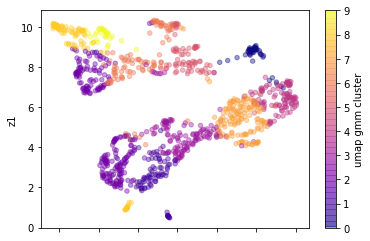

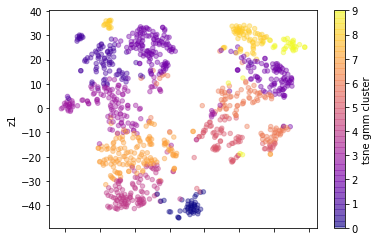

In [5]:
# Step 3: Tessalation

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=10, covariance_type='full', init_params="kmeans", random_state=42
)

gmm.fit(embed_avg)
bic = gmm.bic(embed_avg)
labels = gmm.predict(embed_avg)

print("BIC:", bic)

# Visualize
_ = visualize.plot_cluster(umap_output, labels, "umap gmm cluster")
_ = visualize.plot_cluster(tsne_output, labels, "tsne gmm cluster")

                 0
count  1024.000000
mean    285.914062
std     238.603972
min      25.500000
25%     177.375000
50%     271.000000
75%     297.125000
max    1517.000000


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

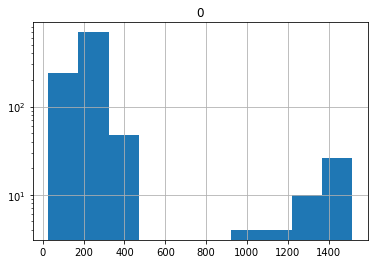

In [26]:
# Step 4: Compute sequence similarity -- precomputed
import json
from biosynseq.metrics import get_seqs_from_fasta

def load_needle_score(gen_fasta_path: Path):

    with open("likely-wood-287-seqs_needle_scores_against_2pwz.json") as f:
        data = json.load(f)
        
    # Need to sort these according to the order of the input fasta file
    similarity_map = {tup[1]: tup[2] for tup in data} # Map: sequence str -> similarity
    seqs = [str(record.seq) for record in get_seqs_from_fasta(gen_fasta_path)]
    sorted_similarity = [similarity_map[seq] for seq in seqs]
    return sorted_similarity    
    

needle_score = load_needle_score(gen_fasta_path) 
    
df = pd.DataFrame(needle_score)
print(df.describe())
df.hist(log=True)

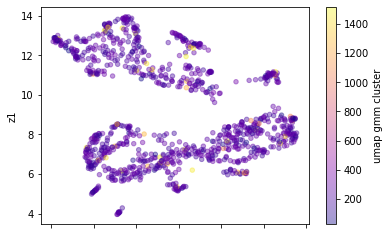

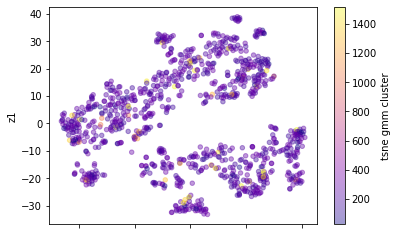

In [60]:
# Visualize
_ = visualize.plot_cluster(umap_output, needle_similarity, "umap gmm cluster", save_dir=Path("."))
_ = visualize.plot_cluster(tsne_output, needle_similarity, "tsne gmm cluster", save_dir=Path("."))

label: 0, count:  44
label: 1, count:  86
label: 2, count:  219
label: 3, count:  131
label: 4, count:  112
label: 5, count:  77
label: 6, count:  102
label: 7, count:  144
label: 8, count:  77
label: 9, count:  32


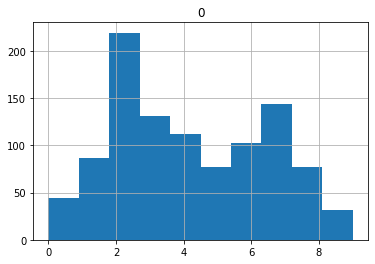

In [7]:
# Step 5: Sample desired_num_seqs * (N_cluster / N) sequences
import random
pd.DataFrame(labels).hist()
for label in np.unique(labels):
    print(f"label: {label}, count: ", len(labels[labels == label]))

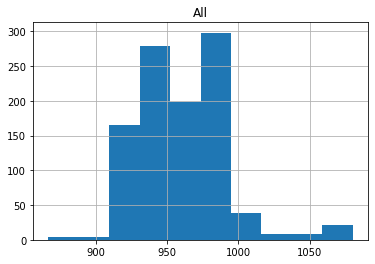

                 0
count  1024.000000
mean    961.708008
std      31.449034
min     867.000000
25%     936.000000
50%     963.000000
75%     987.000000
max    1080.000000


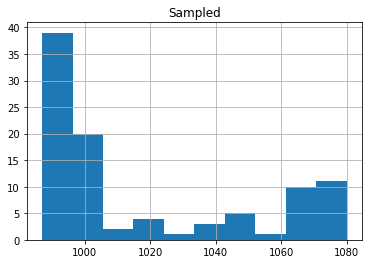

                 0
count    96.000000
mean   1017.937500
std      32.276703
min     987.000000
25%     993.000000
50%    1002.000000
75%    1047.000000
max    1080.000000


In [21]:
def beta_sampling(
    metric: np.ndarray,
    labels: np.ndarray,
    num_to_sample: int,
    alpha: int = 1,
    beta: int = 15a,
    seed: int = 0,
):
    """To maximize over the metric, choose alpha=20, beta=1.
    To minimize, choose alpha=1, beta=20. To uniformly sample,
    choose alpha=1, beta=1. To sample around the mean, choose
    alpha=beta=const (if you increase const, the samples will
    be very close to the mean. Decreasing const will be more
    uniformly distributed.)
    """
    np.random.seed(seed)
    n_examples = len(metric)
    assert n_examples == len(labels)
    assert num_to_sample <= n_examples
    
    clusters = np.unique(labels)
    n_clusters = len(clusters)
    original_inds = np.arange(n_examples)
    
    sampled_inds = {}
    
    for label in clusters:
        # Consider a given cluster
        mask = labels == label
        # Within the cluster, sort the indices by the metric (low to high)
        cluster_inds = np.argsort(metric[mask])
        # Compute the size of the given cluster
        n_cluster = len(cluster_inds)
        # Sample n_cluster / n_seqs samples from the 
        # given cluster in proportion to the metric
        sample_inds = (np.random.beta(a=alpha, b=beta, size=(1000,)) * n_cluster).astype(int)
        # Get unique inds while preserving order
        unique, inds = np.unique(sample_inds, return_index=True)
        unique_inds = unique[np.argsort(inds)]
        unique_inds = cluster_inds[unique_inds]
        # Keep num_to_sample * (n_cluster / n_examples) samples per cluster
        num_to_sample_in_cluster = round(num_to_sample * n_cluster / n_examples)
        assert len(unique_inds) > num_to_sample_in_cluster, "Not enough unique points sampled, run again"
        # Only keep up to num_to_sample_in_cluster per cluster
        unique_inds = unique_inds[:num_to_sample_in_cluster]
        # Get the original indices of the full dataset
        real_inds = original_inds[mask][unique_inds]
        sampled_inds[label] = real_inds
  
    return sampled_inds
    
    
# As an example, minimize sequence length in each cluster
metric = gen_df["SequenceLength"].values.copy()
sampled_inds = beta_sampling(metric, labels, num_to_sample=96, alpha=20, beta=1, seed=42)
inds = np.concatenate(list(sampled_inds.values()))

df = pd.DataFrame(metric)
df.hist()
plt.title("All")
plt.show()
print(df.describe())
df = pd.DataFrame(metric[inds])
df.hist()
plt.title("Sampled")
plt.show()
print(df.describe())


- 1/3 random beta=alpha=1
- We could try sampling for higher chemguass
- Choosing closness to a set of sequences pwz

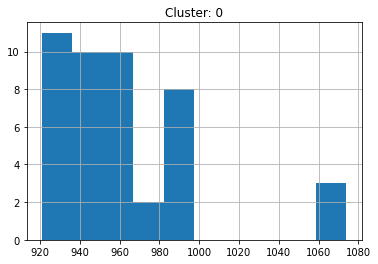

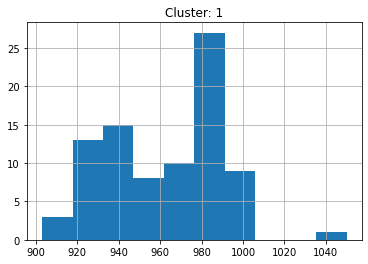

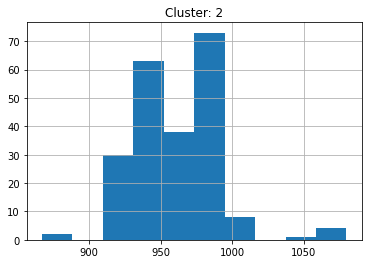

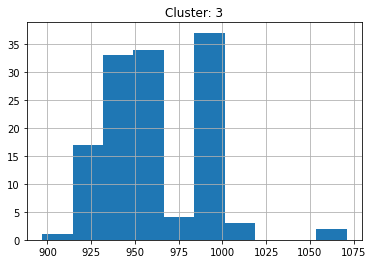

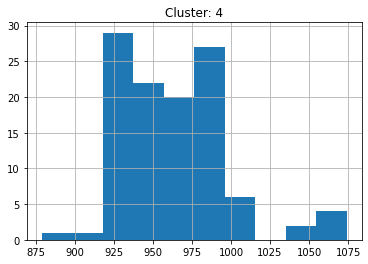

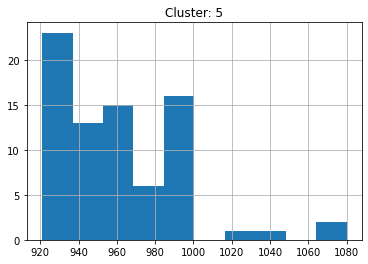

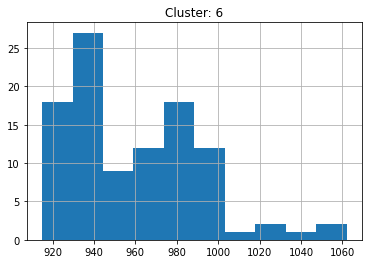

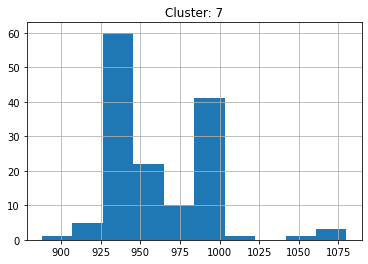

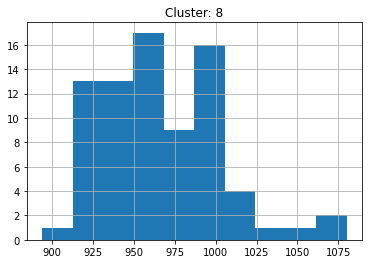

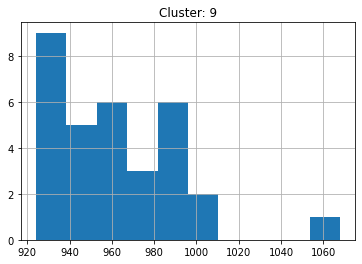

In [51]:
import matplotlib.pyplot as plt

clusters = np.unique(labels)

for label in clusters:
    # Consider a given cluster
    mask = labels == label
    pd.DataFrame(metric[mask]).hist()
    plt.title(f"Cluster: {label}")
    plt.show()

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

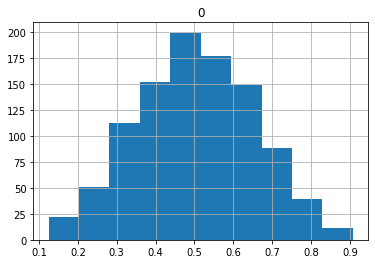

In [40]:
# Beta plotter: Adjust a, b to see the sampling behavior
samples = np.random.beta(a=5, b=5, size=(1000,))
pd.DataFrame(samples).hist()

# Compare train and generated distribution

In [13]:
from biosynseq import visualize

path = Path("/homes/mzvyagin/mdh_gpt2/likely-wood-857/")

train_embed_path = path /"likely-wood-857-train_fasta_embeddings_mean.npy"
train_fasta_path = Path("/homes/mzvyagin/mdh_gpt2/train_folder_concatenated.fasta")

gen_embed_path = path / "likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy"
gen_fasta_path = path / "likely-wood-857_1024concat_seqs.fasta"

train_embed_avg = np.load(train_embed_path)
gen_embed_avg = np.load(gen_embed_path)

train_df = visualize.get_paint_df(train_fasta_path, train_embed_path)
gen_df = visualize.get_paint_df(gen_fasta_path, gen_embed_path)

/lambda_stor/homes/abrace/src/mdlearn/conda-env/lib/python3.7/site-packages/Bio/Seq.py:2983: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [14]:
all_data = np.concatenate([train_embed_avg, gen_embed_avg])
all_data.shape

(30328, 768)

In [15]:
tsne_proj = visualize.run_tsne(all_data)

[W] [17:53:01.835982] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


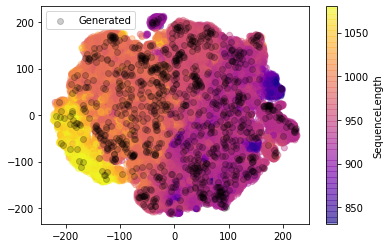

In [37]:
import matplotlib.pyplot as plt

paint_name = "SequenceLength"

df = pd.DataFrame({
        "z0": tsne_proj[:len(train_embed_avg), 0],
        "z1": tsne_proj[:len(train_embed_avg), 1],
        paint_name: train_df[paint_name].values,
})
ax = plt.scatter(x=df.z0, y=df.z1, c=df[paint_name], cmap="plasma", alpha=0.4)
cbar = plt.colorbar(ax)
cbar.set_label(paint_name)
# Generated
df = pd.DataFrame({
        "z0": tsne_proj[len(train_embed_avg):, 0],
        "z1": tsne_proj[len(train_embed_avg):, 1],
        paint_name: gen_df[paint_name].values,
})
plt.scatter(x=df.z0, y=df.z1, c="k", alpha=0.2, label="Generated")
plt.legend(loc="upper left")
plt.show()

# Phylogeny

In [ ]:
# TODO: Could try frobenius norm of the entire (Seqlength, D) tensors.

In [32]:
import itertools
import numpy as np
from tqdm import tqdm
from typing import List
from Bio.SeqRecord import SeqRecord
from scipy.spatial import distance_matrix
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix

def get_distance(embed: np.ndarray, seqs: List[SeqRecord]):
    """Return a DistanceMatrix for transformer embeddings.
    
    Parameters
    ----------
    embed : np.ndarray
        The (N, D) embedding tensor when N is the number of examples
        and D is the hidden dimension.
        
    seqs : List[Bio.SeqRecord]
        List of seqs such that seqs[i] corresponds to embed[i].
            
    """
    pairwise_dists = distance_matrix(embed, embed)
    #names = [s.id for s in seqs]
    names = list(str(i) for i in range(len(seqs)))
    dm = DistanceMatrix(names)
    for seq1_id, seq2_id in tqdm(itertools.combinations(names, 2)):
        dm[seq1_id, seq2_id] = pairwise_dists[int(seq1_id), int(seq2_id)]
    return dm

In [27]:
from pathlib import Path
from biosynseq.metrics import get_seqs_from_fasta

path = Path("/homes/mzvyagin/mdh_gpt2/likely-wood-857")
gen_embed_path = path / "likely-wood-857-1024concat_seqs_fasta_embeddings_mean.npy"
gen_fasta_path = path / "likely-wood-857_1024concat_seqs.fasta"

gen_embed_avg = np.load(gen_embed_path)
gen_seqs = get_seqs_from_fasta(gen_fasta_path)

In [33]:
# https://github.com/biopython/biopython/blob/master/Bio/Phylo/TreeConstruction.py#L546
constructor = DistanceTreeConstructor()

In [34]:
dm = get_distance(gen_embed_avg, gen_seqs)

523776it [01:55, 4546.07it/s]


In [35]:
tree = constructor.nj(dm)

In [37]:
import Bio.Phylo as Phylo
Phylo.write(tree, "mdh-tree-generated-embed.xml", "phyloxml")
Phylo.write(tree, "mdh-tree-generated-embed.tree", "newick")

1